## v0.2 - Exp2
Same as Exp1, but with 30k vocab

In [1]:
from fastai2.text.all import *
from fastai2.callback.all import *
from fastai2.basics import *
import seaborn as sns

from einops import rearrange
import gc
import csv

In [2]:
path = Path('../data/irish/crosslang')
path.ls(), path

((#5) [Path('../data/irish/crosslang/en-ga-crosslang.zip'),Path('../data/irish/crosslang/paracrawl_cleaned_en-ga.csv'),Path('../data/irish/crosslang/paracrawl.ga'),Path('../data/irish/crosslang/paracrawl.en'),Path('../data/irish/crosslang/log')],
 Path('../data/irish/crosslang'))

### Load saved dataset

In [3]:
df=pd.read_csv(path/'paracrawl_cleaned_en-ga.csv')
print(len(df))
df.head()

746502


,ga,en,ga_len,en_len,is_valid
0,Déan agóid in aghaidh iarratas pleanála : : Fingal County Council,Object to a planning application : : Fingal County Council,11,10,True
1,nó cuardach ar ár A-Z,or search our A-Z,5,4,False
2,An dteastaíonn Cead Pleanála uait?,Do You Need Planning Permission,5,5,False
3,Sula dtosaíonn tú ag tógáil,Before you start building,5,4,False
4,Déan agóid in aghaidh iarratas pleanála,Object to a planning application,6,5,False


### Pre-processing

**Remove long texts to make things easier**

In [4]:
# Word count 90th percentile
np.percentile([o for o in df.en_len.values], 90), np.percentile([o for o in df.ga_len.values], 90)

(51.0, 53.0)

In [5]:
print(f'Removing {len(df.query("en_len > 60"))} EN samples where len was > 60')
print(len(df))
df=df[~df.index.isin(df.query("en_len > 60").index)]
print(len(df))
      
print(f'Removing {len(df.query("ga_len > 60"))} FR samples where len was > 60')
print(len(df))
df=df[~df.index.isin(df.query("ga_len > 60").index)]
print(len(df))

Removing 45680 EN samples where len was > 60
746502
700822
Removing 11189 FR samples where len was > 60
700822
689633


(<matplotlib.axes._subplots.AxesSubplot at 0x7efbb5161cd0>, 15.0)

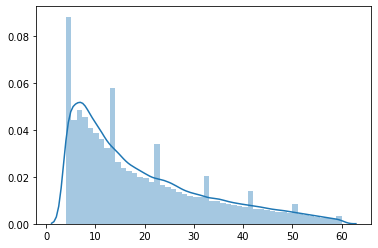

In [6]:
sns.distplot(df['en_len'].values), np.median(df['en_len'])

**Lowercase everything**

In [7]:
df['en'] = df['en'].apply(lambda x:x.lower())
df['ga'] = df['ga'].apply(lambda x:x.lower())

Rules used as part of tokenization

In [8]:
proc_rules=defaults.text_proc_rules[:-1] + [partial(lowercase, add_eos=True)]
proc_rules

[<function fastai2.text.core.fix_html(x)>,
 <function fastai2.text.core.replace_rep(t)>,
 <function fastai2.text.core.replace_wrep(t)>,
 <function fastai2.text.core.spec_add_spaces(t)>,
 <function fastai2.text.core.rm_useless_spaces(t)>,
 <function fastai2.text.core.replace_all_caps(t)>,
 <function fastai2.text.core.replace_maj(t)>,
 functools.partial(<function lowercase at 0x7efb8b2d97a0>, add_eos=True)]

### Get Dataloaders

Load vocab to speed up data loading

In [10]:
# at 30k tokens per vocab sometimes this works, sometimes it doesn't

# Couldnt process 30k tokens until I added the 'hi' below, it was getting stuck at 94.87%, no idea why
@Numericalize
def encodes(self, o): 
    print('hi')
    return TensorText(tensor([self.o2i  [o_] for o_ in o]))

max_vocab=30000
splits = ColSplitter()(df) 

tfms = [[Tokenizer.from_df(text_cols='en' , rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)], 
       [Tokenizer.from_df(text_cols='ga', lang='ga', rules=proc_rules), attrgetter("text"), Numericalize(max_vocab=max_vocab)]]

dl = partial(SortedDL, shuffle=True)

dsets = Datasets(df, tfms, splits=splits, dl_type=dl)

# remove the print from Numericalize
@Numericalize
def encodes(self, o): return TensorText(tensor([self.o2i  [o_] for o_ in o]))

hi


hi


In [ ]:
# en_vocab=[]
# ga_vocab=[]
# with open('paracrawl_vocab_en.csv', newline='') as csvfile:
#     v_reader = csv.reader(csvfile, delimiter=',')
#     for row in v_reader:
#         en_vocab.append(row[0])
        
# with open('paracrawl_vocab_ga.csv', newline='') as csvfile:
#     v_reader = csv.reader(csvfile, delimiter=',')
#     for row in v_reader:
#         ga_vocab.append(row[0])
        
#len(en_vocab), len(ga_vocab), en_vocab[:10], ga_vocab[:10]

In [11]:
len(dsets), splits, len(dsets[2][0]), len(dsets[2][1]), dsets[2]

(689633,
 ((#551742) [1,2,3,4,6,7,9,12,13,14...],
  (#137891) [0,5,8,10,11,18,20,25,27,29...]),
 7,
 8,
 (TensorText([   2,  152,   61,  497,  442, 1141,    3]),
  TensorText([   2,   11, 5234,  542,  715, 3710,  196,    3])))

In [12]:
bs,sl = 48, 108
dls = dsets.dataloaders(bs=bs, seq_len=sl, before_batch=partial(pad_input, pad_fields=[0,1]))
dls.show_batch()

,text,text_
0,"xxbos ( d ) the husband or wife , father , step - father or father - in - law , mother , step - mother or mother - in - law , son , step - son or son - in - law , daughter , step - daughter or daughter - in - law , brother , step - brother or brother - in - law , sister , step - sister or sister - in - law , guardian or trustee , or partner or assistant of any of the persons mentioned in the foregoing paragraphs of this sub - section . xxeos","xxbos ( d ) fear céile nó bean chéile , athair , leas - athair nó athair céile , máthair , leas - mháthair nó máthair chéile , mac , leas - mhac nó xxunk , iníon , leas - iníon , nó xxunk , deartháir , leas - deartháir nó deartháir cleamhnachta , deirfiúr , leas - deirfiúr nó deirfiúr xxunk , caomhnóir nó iontaobhaí , nó páirtnéir nó cúntóir duine ar bith acu san a luaitear sna míreanna san roimhe seo den fho - alt so . xxeos"
1,"xxbos [ ga ] ( d ) debentures , debenture stock , certificates of charge or other forms of security issued by the electricity supply board , radio telefís éireann , the industrial credit corporation p.l.c . , bord telecom éireann , irish telecommunications investments p.l.c . , córas iompair éireann , the agricultural credit corporation , limited , bord na móna , aerlínte éireann , teoranta , aer lingus , teoranta or aer rianta , teoranta . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( d ) bintiúir , stoc bintiúir , deimhnithe muirir nó foirmeacha eile urrúis a d'eisigh bord soláthair an leictreachais , radio telefís éireann , corparáid an chairde tionscail c.p.t . , bord telecom éireann , infheistíochtaí teileachumarsáide na héireann c.p.t . , córas iompair éireann , corparáid an chairde talmhaíochta , teoranta , bord na móna , aerlínte éireann , teoranta , aer lingus , teoranta nó aer rianta , teoranta . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
2,"xxbos ( 2 ) ( a ) in calculating the income , mentioned in paragraph ( b ) of subsection ( 1 ) of section 2 of the old age pensions act , 1911 , of a blind person , no account shall be taken of the earnings of that person except , and in so far as , the annual amount of such earnings is calculated to exceed an amount made up as follows : — xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( 2 ) ( a ) nuair a beifear ag ríomh an ioncaim , a luaitear i mír ( b ) d'fho - alt ( 1 ) d'alt 2 den old age pensions act , 1911 , atá ag dall , ní tabharfar aon aird ar thuilleamh an daill sin ach amháin má háirítear , agus a mhéid a háirítear , suim bhliantúil an tuillimh sin a bheith níos mó ná suim arna comhdhéanamh mar leanas : — xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
3,"xxbos ( 2 ) in section 55 ( 4 ) of the finance act , 1974 , for “ section 214 of the income tax act , 1967 , ” there shall be substituted “ section 15 or 33 ( 2 ) of the corporation tax act , 1976 , ” , and the said section 55 ( 4 ) , as so amended , is set out in the table to this subparagraph . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad","xxbos ( 2 ) in alt 55 ( 4 ) den acht airgeadais , 1974 , cuirfear “ le halt 15 nó 33 ( 2 ) den acht cánach corparáide , 1976 ” in ionad “ le halt 214 den acht cánach ioncaim , 1967 ” , agus tá an t - alt sin 55 ( 4 ) , arna leasú amhlaidh , leagtha amach sa tábla a ghabhann leis an bhfomhír seo . xxeos xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad xxpad"
4,"xxbos ( 4 ) the duty of excise on gaseous hydrocarbons in liquid form imposed by section 41 ( 1 ) of the finance act , 1976 , shall be

Save vocab to speed up data loading

In [13]:
# with open('paracrawl_vocab_en_v0.2_exp2.csv', 'w', newline='') as csvfile:
#     v_writer = csv.writer(csvfile, delimiter=',')
#     for l in dls.vocab[0]:
#         v_writer.writerow([l])
        
# with open('paracrawl_vocab_ga_v0.2_exp2.csv', 'w', newline='') as csvfile:
#     v_writer = csv.writer(csvfile, delimiter=',')
#     for l in dls.vocab[1]:
#         v_writer.writerow([l])

In [14]:
len(dls.train_ds)+len(dls.valid_ds), len(dls.train), len(dls.valid)

(689633, 11494, 2873)

In [15]:
print(f'Vocab lengths are : {len(dls.vocab[0]), len(dls.vocab[1])}')

Vocab lengths are : (30008, 30008)


In [16]:
o=dls.one_batch(); o[0].size(), o[1].size(), o

(torch.Size([48, 106]),
 torch.Size([48, 90]),
 (TensorText([[   2,   15,  197,  ...,   31,   12,    3],
          [   2, 1247, 1475,  ...,    1,    1,    1],
          [   2,   15,   75,  ...,    1,    1,    1],
          ...,
          [   2,   15,   46,  ...,    1,    1,    1],
          [   2,   24, 1739,  ...,    1,    1,    1],
          [   2,   20,  622,  ...,    1,    1,    1]], device='cuda:0'),
  TensorText([[    2,    13,   202,  ...,    90,    12,     3],
          [    2,  1246,  1179,  ...,     1,     1,     1],
          [    2,    13,    94,  ...,     3,     1,     1],
          ...,
          [    2,    13,    47,  ...,     1,     1,     1],
          [    2,  7416,    11,  ...,     1,     1,     1],
          [    2,    32, 11761,  ...,     1,     1,     1]], device='cuda:0')))

## Transformer model

In [17]:
class PositionalEncoding(nn.Module):
    "Encode the position with a sinusoid."
    def __init__(self, d):
        super().__init__()
        self.register_buffer('freq', 1 / (10000 ** (torch.arange(0., d, 2.)/d)))
    
    def forward(self, pos):
        inp = torch.ger(pos, self.freq)
        enc = torch.cat([inp.sin(), inp.cos()], dim=-1)
        return enc

In [18]:
class TransformerEmbedding(nn.Module):
    "Embedding + positional encoding + dropout"
    def __init__(self, vocab_sz, emb_sz, inp_p=0.):
        super().__init__()
        self.emb_sz = emb_sz
        self.embed = Embedding(vocab_sz, emb_sz)
        self.pos_enc = PositionalEncoding(emb_sz)
        self.drop = nn.Dropout(inp_p)
    
    def forward(self, inp): 
        pos = torch.arange(0, inp.size(1), device=inp.device).float()        
        return self.drop(self.embed(inp) * math.sqrt(self.emb_sz) + self.pos_enc(pos))

## PyTorch Transformer Simple

Note: [src/tgt/memory]_mask should be filled with float(‘-inf’) for the masked positions and float(0.0) else. These masks ensure that predictions for position i depend only on the unmasked positions j and are applied identically for each sequence in a batch. 

[src/tgt/memory]_key_padding_mask should be a ByteTensor where True values are positions that should be masked with float(‘-inf’) and False values will be unchanged. This mask ensures that no information will be taken from position i if it is masked, and has a separate mask for each sequence in a batch.

attn mask with -inf
key_padding mask with True

### pt_Transformer

In [19]:
class pt_Transformer(Module):
    def __init__(self, src_vcbsz, trg_vcbsz, n_enc_layers=6, n_dec_layers=6, n_heads=8, d_model=256, d_head=32, 
                 d_inner=1024, p=0.1, bias=True, scale=True, double_drop=True, pad_idx=1):
        self.pad_idx = pad_idx
        self.enc_tfmr_emb = TransformerEmbedding(src_vcbsz, d_model, p)
        self.dec_tfmr_emb = TransformerEmbedding(trg_vcbsz, d_model, 0.)        
        self.final = nn.Linear(d_model, trg_vcbsz)
        
        # !!!
        #self.final.weight = self.dec_tfmr_emb.embed.weight    # !! What does this do?
        
        self.transformer_model=torch.nn.Transformer(d_model=d_model, nhead=n_heads, num_encoder_layers=n_enc_layers, 
                                   num_decoder_layers=n_dec_layers, dim_feedforward=d_inner, dropout=p, 
                                   activation='relu', custom_encoder=None, custom_decoder=None)
    
    
    def forward(self, src, trg, src_mask=None, tgt_mask=None, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None):
        
        enc_emb, dec_emb = self.enc_tfmr_emb(src), self.dec_tfmr_emb(trg)
        
        src_mask=self.transformer_model.generate_square_subsequent_mask(src.size(1)).cuda()
        trg_mask=self.transformer_model.generate_square_subsequent_mask(trg.size(1)).cuda()
        
        dec_out = self.transformer_model(enc_emb.permute(1,0,2), dec_emb.permute(1,0,2),
                                         src_mask=src_mask, tgt_mask=trg_mask, memory_mask=None, 
                        src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)
        
        out=self.final(dec_out)
        
        return out.permute(1,0,2)

### Metric

In [20]:
class CorpusBLEUMetric(Metric):
    def __init__(self, vocab_sz=5000, axis=-1):
        """BLEU Metric calculated over the validation corpus"""
        self.pred_len, self.targ_len, self.corrects, self.counts = 0,0,[0]*4,[0]*4
        self.axis, self.vocab_sz = axis, vocab_sz
        
    def reset(self):
        self.pred_len,self.targ_len,self.corrects,self.counts = 0,0,[0]*4,[0]*4
        
    class NGram():
        def __init__(self, ngram, max_n=5000): self.ngram,self.max_n = ngram,max_n
        def __eq__(self, other):
            if len(self.ngram) != len(other.ngram): return False
            return np.all(np.array(self.ngram) == np.array(other.ngram))
        def __hash__(self): return int(sum([o * self.max_n**i for i,o in enumerate(self.ngram)]))
    
    def get_grams(self, x, n, max_n=5000):
        return x if n==1 else [self.NGram(x[i:i+n], max_n=max_n) for i in range(len(x)-n+1)]
    
    def get_correct_ngrams(self, pred, targ, n, max_n=5000):
        pred_grams,targ_grams = self.get_grams(pred, n, max_n=max_n),self.get_grams(targ, n, max_n=max_n)
        pred_cnt,targ_cnt = Counter(pred_grams),Counter(targ_grams)
        return sum([min(c, targ_cnt[g]) for g,c in pred_cnt.items()]),len(pred_grams)
        
    def accumulate(self, learn):
        last_output = learn.pred.argmax(dim=self.axis)
        last_target = learn.y
        for pred,targ in zip(last_output.cpu().numpy(),last_target.cpu().numpy()):
            self.pred_len += len(pred)
            self.targ_len += len(targ)
            for i in range(4):
                c,t = self.get_correct_ngrams(pred, targ, i+1, max_n=self.vocab_sz)
                self.corrects[i] += c
                self.counts[i]   += t
        
    @property
    def value(self): 
        if self.counts == 0: return None
        else:
            precs = [c/t for c,t in zip(self.corrects,self.counts)]
            len_penalty = exp(1 - self.targ_len/self.pred_len) if self.pred_len < self.targ_len else 1
            return len_penalty * ((precs[0]*precs[1]*precs[2]*precs[3]) ** 0.25)

### Callbacks

#### Present Input and Target in a single tuple

In [21]:
class CombineInputOutputCallback(Callback):
    '''Callback to combine the input and target text into self.xb'''
    def __init__(self): pass
    def begin_batch(self): 
        self.learn.xb = (self.xb[0], self.yb[0])

Shifting and masking of y, from [Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#training):

> We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position i can depend only on the known outputs at positions less than i.

#### Shifting

#### Target shift/offset explained

**Taken from [@bentrevett's brilliant github repo "pytorch-seq2seq" tutorials](https://github.com/bentrevett/pytorch-seq2seq/blob/master/6%20-%20Attention%20is%20All%20You%20Need.ipynb):**

As we want our model to predict the <eos> token but not have it be an input into our model we simply slice the <eos> token off the end of the sequence. Thus:

$$\begin{align*}\text{trg} &= [sos, x_1, x_2, x_3, eos]\\\text{trg[:-1]} &= [sos, x_1, x_2, x_3]\end{align*}$$

$x_i$ denotes **actual** target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the <eos> token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes **predicted** target sequence element. We then calculate our loss using the original trg tensor with the <sos> token sliced off the front, leaving the <eos> token:

$$\begin{align*} \text{output} &= [y_1, y_2, y_3, eos]\\ \text{trg[1:]} &= [x_1, x_2, x_3, eos] \end{align*}$$

We then calculate our losses and update our parameters as is standard.
    
    
We don't want to punish the model for not translating the 'sos' token, but we do need it to predict/define the end of the sentence

**RemoveEOSCallback** 

Cut the *EOS* token token from the **output_x** presented to the model as we are trying to predict the next word. Therefore don't want to model to try anything after the *EOS* token. So the last token given to the model will be the token before *EOS*. This callback is modifies the second element of our learn.xb, (which is the *copied* yb)

But this should also ignore padding, as otherwise we'll be just cutting the last padding token and not the EOS

In [22]:
class RemoveEOSCallback(Callback):
    '''
        Shift the target presented to the model during training to remove the "eos" token as 
        we don't want the model to learn to translate EOS. When it sees EOS.
        
        In practice we actually mask the EOS token as due to batching the last token will often be a <pad> token,
        not EOS
    '''
    def __init__(self, eos_idx): self.eos_idx=eos_idx
    def begin_batch(self):        
        eos_mask=(self.learn.xb[1]!=self.eos_idx)
        sz=torch.tensor(self.learn.xb[1].size())
        sz[1]=sz[1]-1
        self.learn.xb = (self.learn.xb[0], self.learn.xb[1][eos_mask].view((sz[0],sz[1])))

**LossTargetShiftCallback:** Shift the target shown to the loss to exclude the "eos" token, as translating "bos" is not part of our language translation objective

In [23]:
class LossTargetShiftCallback(Callback):
    '''
        Shift the target shown to the loss to exclude the "bos" token as the first token we want predicted
        should be an actual word, not the "bos" token (as we have already given the model "bos" )
    '''
    def __init__(self): pass
    def after_pred(self): 
        self.learn.yb = (self.learn.yb[0][:,1:],)

### Model

Transformer size from Annotated Transformer:

N=6, d_model=512, d_ff=2048, h=8

In [24]:
pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 
n_x_vocab, n_y_vocab = len(dls.vocab[0]), len(dls.vocab[1])
d_model=512
n_heads=8 #12
d_inner=2048  #1024

#model = Transformer(n_x_vocab, n_y_vocab, d_model=d_model, n_heads=n_heads, pad_idx=pad_idx)

model=pt_Transformer(src_vcbsz=n_x_vocab, trg_vcbsz=n_y_vocab, d_model=d_model, d_inner=d_inner)

In [25]:
model

pt_Transformer(
  (enc_tfmr_emb): TransformerEmbedding(
    (embed): Embedding(30008, 512)
    (pos_enc): PositionalEncoding()
    (drop): Dropout(p=0.1, inplace=False)
  )
  (dec_tfmr_emb): TransformerEmbedding(
    (embed): Embedding(30008, 512)
    (pos_enc): PositionalEncoding()
    (drop): Dropout(p=0.0, inplace=False)
  )
  (final): Linear(in_features=512, out_features=30008, bias=True)
  (transformer_model): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=2048, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=2048, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_a

Kaiming_Normal works terrribly, at least if you apply it to everything except LayerNorm...

DistilBERT works ok

Could try xavier:

```
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

model.apply(initialize_weights);
```

**DistilBERT initialisation**

In [26]:
# DistilERT HF init weights https://github.com/huggingface/transformers/blob/31e67dd19f1b3fe2bc9a13f86d814f3f7bba48e4/src/transformers/modeling_distilbert.py

def distil_apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)


def _distilbert_init_weights(module):
    """ Initialize the weights.
    """
    if isinstance(module, nn.Embedding):
        if module.weight.requires_grad:
            module.weight.data.normal_(mean=0.0, std=0.02) #std=self.config.initializer_range)
    if isinstance(module, nn.Linear):
        module.weight.data.normal_(mean=0.0, std=0.02) #self.config.initializer_range)
    elif isinstance(module, nn.LayerNorm):
        module.bias.data.zero_()
        module.weight.data.fill_(1.0)
    if isinstance(module, nn.Linear) and module.bias is not None:
        module.bias.data.zero_()

distil_apply_leaf(model, _distilbert_init_weights)

In [27]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 90,262,840 trainable parameters


### Learner

In [28]:
cbs = [CombineInputOutputCallback, RemoveEOSCallback(eos_idx=3), LossTargetShiftCallback]

pad_idx=1
assert dls.vocab[1][pad_idx] == 'xxpad' 
loss_func = CrossEntropyLossFlat(ignore_index=pad_idx)

learn = Learner(dls, model, metrics=[accuracy, Perplexity(), CorpusBLEUMetric(vocab_sz=n_y_vocab)], 
                cbs=cbs, loss_func=loss_func)

In [29]:
#learn.load('paracrawl_en_ga_5e_5e-4')

# Training

SuggestedLRs(lr_min=0.002754228748381138, lr_steep=0.001737800776027143)

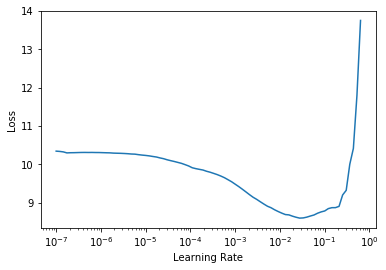

In [30]:
learn.lr_find()

In [31]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,accuracy,perplexity,corpus_bleu,time
0,1.781779,1.747722,0.478246,5.741511,0.312570,24:40
1,1.297791,1.373945,0.519854,3.950907,0.363953,24:43
2,1.007788,1.144678,0.546649,3.141430,0.405859,24:44
3,0.814164,1.010174,0.563252,2.746078,0.433127,24:47
4,0.722611,0.969637,0.568647,2.636986,0.442531,24:40


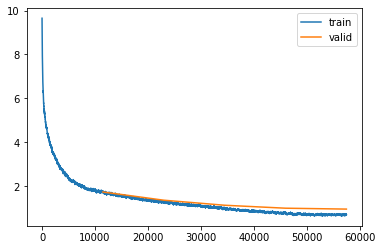

In [32]:
learn.recorder.plot_loss()

In [33]:
learn.save('paracrawl_en_ga_5e_5e-4_v0.2_exp2')

## 5e results

In [34]:
def generate(model, sentence, vocab):
    #model = torch.load('output/transformer.pth')
#     lang_model = spacy.load('en')
#     with open('data/processed/en/freq_list.pkl', 'rb') as f:
#         en_freq_list = pickle.load(f)
#     with open('data/processed/fr/freq_list.pkl', 'rb') as f:
#         fr_freq_list = pickle.load(f)
    #sentence = input('Please enter your english sentence: ')
    #sentence = tokenize(sentence, en_freq_list, lang_model)
    
    model=model.eval()
    
    sentence=learn.dls.tokenizer[0][1].encodes(sentence)
    sentence=learn.dls.numericalize[0].encodes(sentence)
    
    translated_sentence = [2] # xxbos
    #translated_sentence = [fr_freq_list['[SOS]']]
    i = 0
    while int(translated_sentence[-1]) != 3 and i < 75:   # xxeos
    #while int(translated_sentence[-1]) != fr_freq_list['[EOS]'] and i < 15:
        #output = forward_model(model, sentence, translated_sentence).to('cuda')
        output = forward_model(model, sentence, translated_sentence).cuda()
        values, indices = torch.topk(output, 5)
        translated_sentence.append(int(indices[-1][0]))
        i+=1

    detok_translated_sentence=detokenize(translated_sentence, vocab)
    print(' '.join(detok_translated_sentence))
    

def forward_model(model, src, tgt):
    src = torch.as_tensor(src).unsqueeze(0).long().cuda()
    tgt = torch.as_tensor(tgt).unsqueeze(0).cuda()
    tgt_mask = gen_nopeek_mask(tgt.shape[1]).cuda()
    output = model.forward(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)

    #return output.squeeze(0).to('cpu')
    return output.squeeze(0).detach()


# def tokenize(sentence, freq_list, lang_model):
#     punctuation = ['(', ')', ':', '"', ' ']

#     sentence = sentence.lower()
#     sentence = [tok.text for tok in lang_model.tokenizer(sentence) if tok.text not in punctuation]
#     return [freq_list[word] if word in freq_list else freq_list['[OOV]'] for word in sentence]


def detokenize(sentence, vocab):
    #freq_list = {v: k for k, v in freq_list.items()}
    return [vocab[token] for token in sentence]
    #return [freq_list[token] for token in sentence]
# def detokenize(sentence, freq_list):
#     freq_list = {v: k for k, v in freq_list.items()}
#     return [freq_list[token] for token in sentence]


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

In [35]:
generate(learn.model, "hello, how are you?", dls.vocab[1])

xxbos dia duit , conas a bhfuil tú ? xxeos


In [36]:
generate(learn.model, "Can you tell we where the bus station is please?", dls.vocab[1])

xxbos is féidir xxunk insint duit nuair a bhíonn an stáisiún bus le do thoil ? xxeos


In [37]:
generate(learn.model, "Yesterday it rained, but tomorrow will be very sunny", dls.vocab[1])

xxbos xxunk inné sé xxunk , ach amárach beidh an - grianmhar xxeos


In [38]:
generate(learn.model, "I had a great day, my translator is working", dls.vocab[1])

xxbos bhí mé lá iontach , is é mo aistritheoir ag obair xxeos


In [39]:
generate(learn.model, "So this is a story all about how my lift got flip turned \
upside down, so I'd like to take a minute just sit right there, I'll you all about how I became the fresh prince\
of belair", dls.vocab[1])

xxbos xxunk sin scéal faoi conas a fuair mo ardaitheoir xxunk xxunk síos , mar sin xxunk mhaith liom a ghlacadh nóiméad ach suí ceart ann , xxunk beidh mé tú ar fad faoi conas a tháinig mé ar an xxunk úr xxeos


In [40]:
generate(learn.model, "dog", dls.vocab[1])

xxbos madra xxeos


In [41]:
generate(learn.model, "cat", dls.vocab[1])

xxbos cat cat xxeos


In [42]:
generate(learn.model, "tree", dls.vocab[1])

xxbos crann xxeos


In [43]:
generate(learn.model, "building", dls.vocab[1])

xxbos foirgneamh xxeos


In [44]:
generate(learn.model, "city", dls.vocab[1])

xxbos cathair xxeos


In [45]:
generate(learn.model, "woman", dls.vocab[1])

xxbos bhean xxeos


In [46]:
generate(learn.model, "man", dls.vocab[1])

xxbos fear xxeos


In [47]:
generate(learn.model, "chocolate", dls.vocab[1])

xxbos seacláid xxeos


In [48]:
generate(learn.model, "spaceship", dls.vocab[1])

xxbos spásárthach xxeos


## v0.1 - 5e Run

In [47]:
learn.fit_one_cycle(5, 5e-4, div=5)

epoch,train_loss,valid_loss,accuracy,perplexity,corpus_bleu,time
0,1.653487,1.684406,0.479604,5.389246,0.310178,24:02
1,1.302716,1.293889,0.524035,3.646941,0.370828,24:00
2,0.956889,1.114578,0.547175,3.048281,0.405713,24:04
3,0.745926,0.990513,0.564060,2.692616,0.432489,24:22
4,0.719075,0.947289,0.569523,2.578710,0.441353,24:01


In [48]:
learn.save('paracrawl_en_ga_5e_5e-4')

In [56]:
learn.export(fname='paracrawl_en_ga_5e_5e-4_learner.pkl')

## Generation

## 5e results

In [50]:
generate(learn.model, "hello, how are you?", dls.vocab[1])

xxbos dia duit , conas a bhfuil t ? xxeos


In [51]:
generate(learn.model, "Can you tell we where the bus station is please?", dls.vocab[1])

xxbos is fidir xxunk insint duit nuair a bhonn an stisin bus le do thoil ? xxeos


In [52]:
generate(learn.model, "Yesterday it rained, but tomorrow will be very sunny", dls.vocab[1])

xxbos xxunk inn xxunk s , ach beidh amrach a bheith an - xxunk xxeos


In [53]:
generate(learn.model, "I had a great day, my translator is working", dls.vocab[1])

xxbos bh m l iontach , t mo aistritheoir ag obair xxeos


In [54]:
generate(learn.model, "So this is a story all about how my lift got flip turned \
upside down, so I'd like to take a minute just sit right there, I'll you all about how I became the fresh prince\
of belair", dls.vocab[1])

xxbos xxunk mar sin is seo an scal ar fad faoi conas a fuair mo ardaitheoir smeach xxunk sos , mar sin xxunk ba mhaith liom a ghlacadh nimad ach su ceart ann , xxunk m go mbainfidh t go lir faoi conas a thinig m an xxunk r xxunk xxeos


In [58]:
generate(learn.model, "dog", dls.vocab[1])

xxbos madra xxeos


In [59]:
generate(learn.model, "cat", dls.vocab[1])

xxbos cat cat xxeos


In [60]:
generate(learn.model, "tree", dls.vocab[1])

xxbos crann xxeos


In [61]:
generate(learn.model, "building", dls.vocab[1])

xxbos foirgneamh xxeos


In [62]:
generate(learn.model, "city", dls.vocab[1])

xxbos cathair na mart xxeos


In [63]:
generate(learn.model, "woman", dls.vocab[1])

xxbos bean xxeos


In [65]:
generate(learn.model, "man", dls.vocab[1])

xxbos fear xxeos


In [64]:
generate(learn.model, "chocolate", dls.vocab[1])

xxbos seaclid seaclid seaclid xxeos


In [66]:
generate(learn.model, "spaceship", dls.vocab[1])

xxbos spsrthach spsrthach xxeos


## 20e Run

In [50]:
# 20e, added shuffle to sorteddl, PT Transformer, distilbert init, Adam, distilbert init
# CONCLUSION: 
learn.fit_one_cycle(20, 5e-4, div=5)

epoch,train_loss,valid_loss,accuracy,perplexity,corpus_bleu,time
0,1.636746,1.624053,0.490452,5.073614,0.324452,22:39
1,1.260920,1.325647,0.520619,3.764619,0.366522,22:41
2,1.232290,1.289559,0.525144,3.631185,0.372480,23:00
3,1.171967,1.256577,0.530127,3.513375,0.378737,23:07
4,1.081539,1.233820,0.534953,3.434322,0.385957,22:55
5,1.021572,1.175043,0.540957,3.238282,0.395813,22:44
6,0.962378,1.145241,0.546696,3.143200,0.404170,23:03
7,0.893671,1.105928,0.551453,3.022028,0.412557,22:47
8,0.868382,1.097856,0.555033,2.997732,0.419388,22:56
9,0.788918,1.052471,0.559421,2.864722,0.425994,22:58


In [51]:
learn.save('paracrawl_en_ga_20e_5e-4')

In [52]:
learn.export(fname='paracrawl_en_ga_20e_5e-4_learner.pkl')

## Generation

In [53]:
def generate(model, sentence, vocab):
    #model = torch.load('output/transformer.pth')
#     lang_model = spacy.load('en')
#     with open('data/processed/en/freq_list.pkl', 'rb') as f:
#         en_freq_list = pickle.load(f)
#     with open('data/processed/fr/freq_list.pkl', 'rb') as f:
#         fr_freq_list = pickle.load(f)
    #sentence = input('Please enter your english sentence: ')
    #sentence = tokenize(sentence, en_freq_list, lang_model)
    
    model=model.eval()
    
    sentence=learn.dls.tokenizer[0][1].encodes(sentence)
    sentence=learn.dls.numericalize[0].encodes(sentence)
    
    translated_sentence = [2] # xxbos
    #translated_sentence = [fr_freq_list['[SOS]']]
    i = 0
    while int(translated_sentence[-1]) != 3 and i < 75:   # xxeos
    #while int(translated_sentence[-1]) != fr_freq_list['[EOS]'] and i < 15:
        #output = forward_model(model, sentence, translated_sentence).to('cuda')
        output = forward_model(model, sentence, translated_sentence).cuda()
        values, indices = torch.topk(output, 5)
        translated_sentence.append(int(indices[-1][0]))
        i+=1

    detok_translated_sentence=detokenize(translated_sentence, vocab)
    print(' '.join(detok_translated_sentence))
    

def forward_model(model, src, tgt):
    src = torch.as_tensor(src).unsqueeze(0).long().cuda()
    tgt = torch.as_tensor(tgt).unsqueeze(0).cuda()
    tgt_mask = gen_nopeek_mask(tgt.shape[1]).cuda()
    output = model.forward(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask=None, tgt_key_padding_mask=None, memory_key_padding_mask=None)

    #return output.squeeze(0).to('cpu')
    return output.squeeze(0).detach()


# def tokenize(sentence, freq_list, lang_model):
#     punctuation = ['(', ')', ':', '"', ' ']

#     sentence = sentence.lower()
#     sentence = [tok.text for tok in lang_model.tokenizer(sentence) if tok.text not in punctuation]
#     return [freq_list[word] if word in freq_list else freq_list['[OOV]'] for word in sentence]


def detokenize(sentence, vocab):
    #freq_list = {v: k for k, v in freq_list.items()}
    return [vocab[token] for token in sentence]
    #return [freq_list[token] for token in sentence]
# def detokenize(sentence, freq_list):
#     freq_list = {v: k for k, v in freq_list.items()}
#     return [freq_list[token] for token in sentence]


def gen_nopeek_mask(length):
    mask = rearrange(torch.triu(torch.ones(length, length)) == 1, 'h w -> w h')
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

## 20e results

In [54]:
generate(learn.model, "hello, how are you?", dls.vocab[1])

xxbos dia duit , conas a bhfuil t ? xxeos


In [55]:
generate(learn.model, "Can you tell we where the bus station is please?", dls.vocab[1])

xxbos xxunk an fidir leat insint dinn c bhfuil an stisin bus le do thoil ? xxeos


In [56]:
generate(learn.model, "Yesterday it rained, but tomorrow will be very sunny", dls.vocab[1])

xxbos xxunk inn xxunk s , ach beidh amrach a bheith an - xxunk xxeos


In [57]:
generate(learn.model, "I had a great day, my translator is working", dls.vocab[1])

xxbos bh m l mr , t mo aistritheoir ag obair xxeos


In [58]:
generate(learn.model, "So this is a story all about how my lift got flip turned \
upside down, so I'd like to take a minute just sit right there, I'll you all about how I became the fresh prince\
of belair", dls.vocab[1])

xxbos xxunk mar sin t an scal faoi conas a fuair mo ardaitheoir smeach xxunk sos , mar sin xxunk ba mhaith liom a ghlacadh nimad ach su ceart ann , xxunk beidh m go lir faoi conas a thinig m an xxunk r xxunk xxeos


In [59]:
generate(learn.model, "dog", dls.vocab[1])

xxbos madra xxeos


In [60]:
generate(learn.model, "cat", dls.vocab[1])

xxbos cat xxeos


In [61]:
generate(learn.model, "tree", dls.vocab[1])

xxbos crann xxeos


In [62]:
generate(learn.model, "building", dls.vocab[1])

xxbos foirgneamh xxeos


In [63]:
generate(learn.model, "city", dls.vocab[1])

xxbos cathair xxeos


In [64]:
generate(learn.model, "woman", dls.vocab[1])

xxbos bean xxeos


In [65]:
generate(learn.model, "man", dls.vocab[1])

xxbos fear xxeos


In [66]:
generate(learn.model, "chocolate", dls.vocab[1])

xxbos seaclid xxeos


In [67]:
generate(learn.model, "spaceship", dls.vocab[1])

xxbos spsrthach xxeos


## Alternative generation

In [ ]:
# https://forums.fast.ai/t/fastai-v2-text/53529/334
from fastai2.text.all import *

defaults.device = torch.device('cpu')
path = Path('.')
learner = load_learner("./export.pkl")

f = open("/tmp/test.txt", "r")
test_file_contents = f.read()

_, _, losses = learner.predict(test_file_contents)
cats = [learner.dls.categorize.decode(i) for i in range(len(losses))]

predictions = sorted(
    zip(cats, map(float, losses)),
    key=lambda p: p[1],
    reverse=True
)
print(predictions)

# OR

items = pd.read_csv("/tmp/test.txt", sep = '\t')
test_dl = learner.dls.test_dl(items.values)

learner.get_preds(dl=test_dl, with_decoded=False)